# Задание-1

В ноутбуке про многоруких бандитов мы разбирали классы для реализации отдельных стратегий решения задачки. Реализуйте в той же парадигме стратегии [exp3](https://jamesrledoux.com/algorithms/bandit-algorithms-epsilon-ucb-exp-python/) и [softmax](https://gibberblot.github.io/rl-notes/single-agent/multi-armed-bandits.html) стратегии. Да, вы не ошиблись, они уже сделаны, надо понять, как оно работает и сделать так, чтобы оно работало в использованной нами конфигурации)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

class BernoulliBandit:
    def __init__(self, n, probas=None):
        self.n = n
        self.probas = probas if probas is not None else np.random.rand(n)
        self.best_proba = max(self.probas)

    def generate_reward(self, i):
        return np.random.rand() < self.probas[i]

class Solver:
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(bandit.n, dtype=int)
        self.actions = []
        self.regrets = [0.]

    def update_regret(self, i):
        self.regrets.append(self.regrets[-1] + self.bandit.best_proba - self.bandit.probas[i])

    @property
    def estimated_probas(self):
        raise NotImplementedError

    def run_one_step(self):
        raise NotImplementedError

    def run(self, num_steps):
        for _ in range(num_steps):
            i = self.run_one_step()
            self.counts[i] += 1
            self.update_regret(i)

In [2]:
class EXP3(Solver):
    def __init__(self, bandit, gamma, init_a=1, init_b=1):
        super().__init__(bandit)
        self.weights = np.ones(bandit.n)
        self.gamma = gamma
        self._as = np.full(bandit.n, init_a, dtype=float)
        self._bs = np.full(bandit.n, init_b, dtype=float)

    @property
    def estimated_probas(self):
        estimated = self._as / (self._as + self._bs)
        return np.nan_to_num(estimated, nan=1.0 / self.bandit.n)

    def run_one_step(self):
        with np.errstate(divide='ignore', invalid='ignore'):
            probabilities = (1 - self.gamma) * np.nan_to_num(self.weights / np.sum(self.weights)) + self.gamma / self.bandit.n
            probabilities = np.nan_to_num(probabilities, nan=1.0 / self.bandit.n)
            probabilities /= np.sum(probabilities)

        selected_bandit = np.random.choice(self.bandit.n, p=probabilities)
        r = self.bandit.generate_reward(selected_bandit)
        
        self.weights[selected_bandit] *= np.exp(self.gamma * r / probabilities[selected_bandit] / self.bandit.n)
        self._as[selected_bandit] += r
        self._bs[selected_bandit] += 1 - r
        return selected_bandit

In [3]:
class Softmax(Solver): 
    def __init__(self, bandit, tau=1.0, init_a=1, init_b=1): 
        super(Softmax, self).__init__(bandit) 
        self.num_bandits = bandit.n 
        self.tau = tau 
        self._as = [init_a] * bandit.n 
        self._bs = [init_b] * bandit.n 
        self.estimated_reward = np.ones(bandit.n) 
 
    @property 
    def estimated_probas(self): 
        return [self._as[i] / (self._as[i] + self._bs[i]) for i in range(self.num_bandits)] 
 
    def run_one_step(self): 
        # Интегрирование softmax непосредственно в метод run_one_step 
        shifted_rewards = self.estimated_reward / self.tau - np.max(self.estimated_reward / self.tau) 
        exp_rewards = np.exp(shifted_rewards) 
        probabilities = exp_rewards / np.sum(exp_rewards) 
 
        selected_bandit = np.random.choice(self.num_bandits, p=probabilities) 
        r = self.bandit.generate_reward(selected_bandit) 
        self.estimated_reward[selected_bandit] += r 
        self._as[selected_bandit] += r
        self._bs[selected_bandit] += 1 - r
 
        return selected_bandit


In [4]:
def plot_results(solvers, solver_names):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))
    for i, s in enumerate(solvers):
        axs[0].plot(s.regrets, label=solver_names[i])
    axs[0].set_xlabel('Время')
    axs[0].set_ylabel('Накопленная ошибка')
    axs[0].legend()
    axs[0].grid()

    for s in solvers:
        axs[1].plot(s.estimated_probas, 'x', label=solver_names[solvers.index(s)])
    axs[1].plot(solvers[0].bandit.probas, 'k--', label='True probabilities')
    axs[1].set_xlabel('Ручки, отсортированные по ' + r'$\theta$')
    axs[1].set_ylabel('Оцененная алгоритмом '+ r'$\hat\theta$')
    axs[1].grid()

    for s in solvers:
        axs[2].plot(s.counts / sum(s.counts), label=solver_names[solvers.index(s)])
    axs[2].set_xlabel('Ручки')
    axs[2].set_ylabel('Доля каждой ручки в общем кол-ве действий')
    axs[2].grid()
    plt.show()

In [5]:
def experiment(K, N):
    bandit = BernoulliBandit(K)
    print("True win probabilities:\n", bandit.probas)
    print("Best arm index:", np.argmax(bandit.probas), "with probability:", max(bandit.probas))

    solvers = [EXP3(bandit, 0.1), Softmax(bandit, 2.0)]
    names = ['EXP3', 'Softmax']

    for s in solvers:
        s.run(N)
    plot_results(solvers, names)

True win probabilities:
 [0.76654932 0.53361575 0.29601405 0.08825816 0.09508622 0.45847638
 0.32690945 0.16510668 0.7872147  0.34065246]
Best arm index: 8 with probability: 0.787214703405547


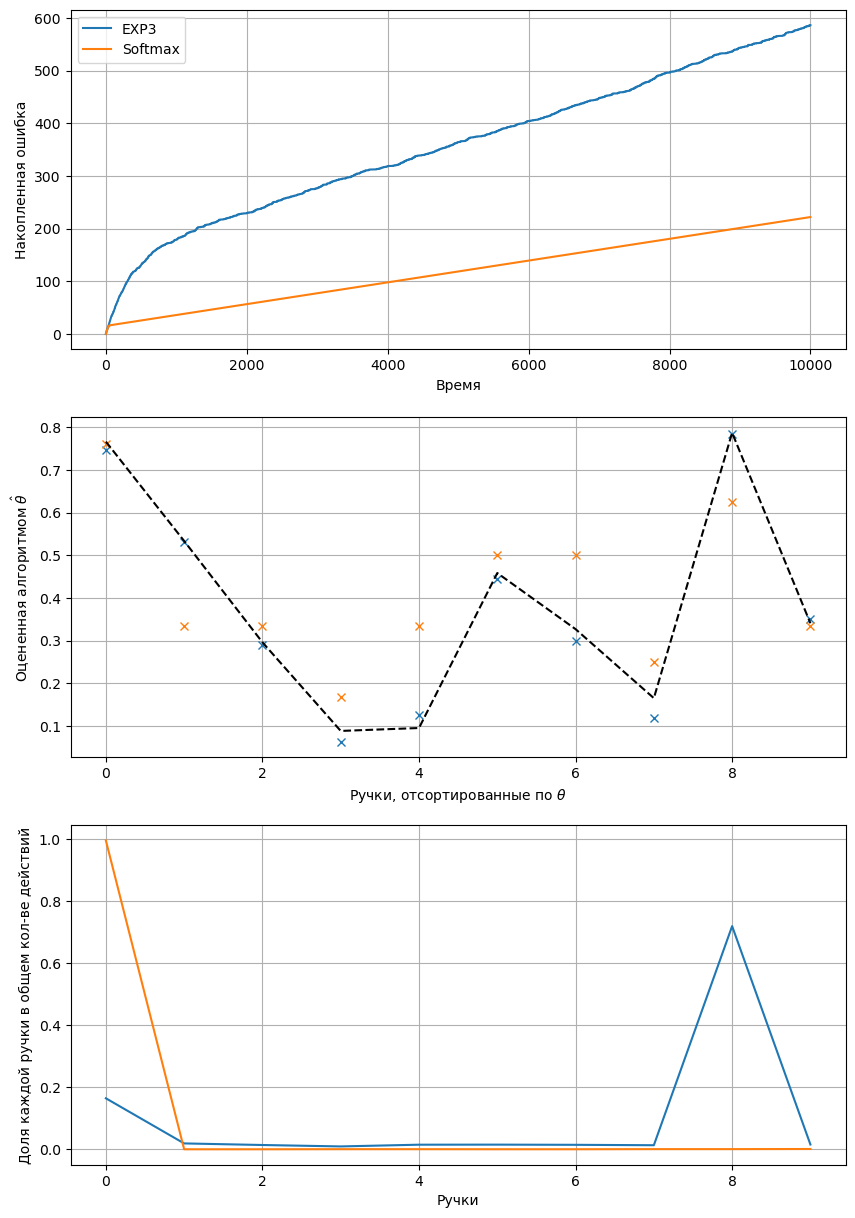

In [6]:
experiment(10,10000)

# Задание 2

В ДЗ по ML вы уже реализовали классы для того, чтобы делать логистические регрессии. Релизуйте класс, который будет из этих регрессий собирать полносвязный перцептрон из 2 слоев с 2 нейронами каждый и третьего выходного слоя. В качестве функции активации используйте сигмоиду, как в логистической регрессии. Если сделаете возможность в качестве активации выбирать ReLu и tanh в дополнение к сигмоиде, будете большими молодцами. Если можно будет задавать количество слоев и количество нейронов в слое, будете вдвойне молодцами) (но базовое требование - два слоя по два нейрона кадлый + 1 выходной слой) 

[Пример](https://github.com/pileyan/ML-From-Scratch/blob/master/mlfromscratch/supervised_learning/multilayer_perceptron.py)

Да, вы снова не ошиблись! реализация уже есть! Но у нас же тут с Вами курс по ПИТОНУ, а не ML :D

Про перцептрон [раз](https://www.simplilearn.com/tutorials/deep-learning-tutorial/perceptron), [два](https://mlcourse.at.ispras.ru/wp-content/uploads/2020/09/intro_to_nn_2020.pdf)

In [7]:
import numpy as np 
import math 

class Loss: 
    def loss(self, y_true, y_pred): 
        raise NotImplementedError 
 
    def gradient(self, y, y_pred): 
        raise NotImplementedError 
 
class ActivationFunction: 
    def __call__(self, x): 
        raise NotImplementedError 
 
    def gradient(self, x): 
        raise NotImplementedError 
 
class Sigmoid(ActivationFunction): 
    def __call__(self, x): 
        return 1 / (1 + np.exp(-x)) 
 
    def gradient(self, x): 
        return self.__call__(x) * (1 - self.__call__(x))
    
class Tanh(ActivationFunction): 
    def __call__(self, x):
        e = np.exp(1)
        return (e**x - e**(-x))/((e**x + e**(-x)))

    def gradient(self, x): 
        return self.__call__(x) * (1 - self.__call__(x))     
    
 
class ReLU(ActivationFunction): 
    def __call__(self, x): 
        return np.maximum(0, x) 
 
    def gradient(self, x): 
        return (x > 0).astype(int) 
 
class Softmax(ActivationFunction): 
    def __call__(self, x): 
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True)) 
        return e_x / e_x.sum(axis=-1, keepdims=True) 
 
    def gradient(self, x): 
        p = self.__call__(x) 
        return p * (1 - p) 
 
class CrossEntropy(Loss): 
    def loss(self, y, p): 
        p = np.clip(p, 1e-15, 1 - 1e-15) 
        return -y * np.log(p) - (1 - y) * np.log(1 - p) 
 
    def gradient(self, y, p): 
        p = np.clip(p, 1e-15, 1 - 1e-15) 
        return -(y / p) + (1 - y) / (1 - p)

In [8]:
class MultilayerPerceptron():
    """Multilayer Perceptron classifier. A fully-connected neural network with one hidden layer.
    Unrolled to display the whole forward and backward pass.

    Parameters:
    -----------
    n_hidden: int:
        The number of processing nodes (neurons) in the hidden layer.
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, n_hidden_1, n_hidden_2, activation_function = ReLU(), n_iterations=3000, learning_rate=0.01):
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.hidden_activation = activation_function
        self.output_activation = Softmax()
        self.loss = CrossEntropy()

    def _initialize_weights(self, X, y):
        n_samples, n_features = X.shape
        _, n_outputs = y.shape
        # Hidden layer
        limit   = 1 / math.sqrt(n_features)
        self.W  = np.random.uniform(-limit, limit, (n_features, self.n_hidden_1))
        self.w0 = np.zeros((1, self.n_hidden_1))

        limit   = 1 / math.sqrt(self.n_hidden_1)
        self.W1  = np.random.uniform(-limit, limit, (self.n_hidden_1, self.n_hidden_2))
        self.w01 = np.zeros((1, self.n_hidden_2))

        # Output layer
        limit   = 1 / math.sqrt(self.n_hidden_2)
        self.V  = np.random.uniform(-limit, limit, (self.n_hidden_2, n_outputs))
        self.v0 = np.zeros((1, n_outputs))

    def fit(self, X, y):

        self._initialize_weights(X, y)

        for i in range(self.n_iterations):

            # ..............
            #  Forward Pass
            # ..............

            # HIDDEN LAYER
            hidden_input = X.dot(self.W) + self.w0
            hidden_output = self.hidden_activation(hidden_input)

            hidden_input_1 = hidden_output.dot(self.W1) + self.w01
            hidden_output_1 = self.hidden_activation(hidden_input_1)
            # OUTPUT LAYER
            output_layer_input = hidden_output_1.dot(self.V) + self.v0
            y_pred = self.output_activation(output_layer_input)

            # ...............
            #  Backward Pass
            # ...............

            # OUTPUT LAYER
            # Grad. w.r.t input of output layer
            grad_wrt_out_l_input = self.loss.gradient(y, y_pred) * self.output_activation.gradient(output_layer_input)
            grad_v = hidden_output_1.T.dot(grad_wrt_out_l_input)
            grad_v0 = np.sum(grad_wrt_out_l_input, axis=0, keepdims=True)
            # HIDDEN LAYER
            # Grad. w.r.t input of hidden layer
            grad_wrt_hidden_l_input_1 = grad_wrt_out_l_input.dot(self.V.T) * self.hidden_activation.gradient(hidden_input_1)
            grad_w_1 = hidden_output.T.dot(grad_wrt_hidden_l_input_1)
            grad_w0_1 = np.sum(grad_wrt_hidden_l_input_1, axis=0, keepdims=True)

            grad_wrt_hidden_l_input = grad_wrt_hidden_l_input_1.dot(self.W1.T) * self.hidden_activation.gradient(hidden_input)
            grad_w = X.T.dot(grad_wrt_hidden_l_input)
            grad_w0 = np.sum(grad_wrt_hidden_l_input, axis=0, keepdims=True)

            # Update weights (by gradient descent)
            # Move against the gradient to minimize loss
            self.V  -= self.learning_rate * grad_v
            self.v0 -= self.learning_rate * grad_v0
            self.W1  -= self.learning_rate * grad_w_1
            self.w01 -= self.learning_rate * grad_w0_1
            self.W  -= self.learning_rate * grad_w
            self.w0 -= self.learning_rate * grad_w0

    # Use the trained model to predict labels of X
    def predict(self, X):
        # Forward pass:
        hidden_input = X.dot(self.W) + self.w0
        hidden_output = self.hidden_activation(hidden_input)
        hidden_input = hidden_output.dot(self.W1) + self.w01
        hidden_output = self.hidden_activation(hidden_input)
        output_layer_input = hidden_output.dot(self.V) + self.v0
        y_pred = self.output_activation(output_layer_input)
        return y_pred

In [9]:
def to_categorical(x, num_classes=None): 
    """  
    One-hot encoding of nominal values. 
     
    Args: 
    x (array-like): Array-like input data (integer values). 
    num_classes (int, optional): Number of categories.  
                                 If None, it will be inferred from the input data. 
 
    Returns: 
    np.ndarray: One-hot encoded representation of the input. 
    """ 
    # If num_classes is not provided, infer it from the input data 
    if num_classes is None: 
        num_classes = np.max(x) + 1 
 
    # Initialize the one-hot encoded array with zeros 
    one_hot_encoded = np.zeros((len(x), num_classes)) 
 
    # Set the appropriate elements to 1 
    one_hot_encoded[np.arange(len(x)), x] = 1 
 
    return one_hot_encoded

In [18]:
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


for i, loss_function in enumerate([Sigmoid(), Tanh(), ReLU()]):

    data = datasets.load_breast_cancer()
    X = data.data
    y = data.target
    y = to_categorical(y)

    SS = StandardScaler()    

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True)

    X_train = SS.fit_transform(X_train)
    X_test = SS.transform(X_test)

    l_functions = ['Sigmoid', 'Tanh', 'ReLU']


    clf = MultilayerPerceptron(n_hidden_1=32, n_hidden_2=16, activation_function= loss_function, n_iterations=10000, learning_rate=0.01)
    clf.fit(X_train, y_train)
    y_pred = np.argmax(clf.predict(X_test), axis=1)
    y_test = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy {l_functions[i]}:", accuracy)

Accuracy Sigmoid: 0.9649122807017544


C:\Users\Spacelight\AppData\Local\Temp\ipykernel_11640\3768575748.py:28: RuntimeWarning: overflow encountered in power
  return (e**x - e**(-x))/((e**x + e**(-x)))
C:\Users\Spacelight\AppData\Local\Temp\ipykernel_11640\3768575748.py:28: RuntimeWarning: invalid value encountered in divide
  return (e**x - e**(-x))/((e**x + e**(-x)))


Accuracy Tanh: 0.3508771929824561
Accuracy ReLU: 0.9780701754385965


In [1]:
a = [i for i in range(0,5)] 
print(a)

[0, 1, 2, 3, 4]
